## Imports

In [4]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import random
random.seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Module
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import transforms
from torch.autograd import Variable

from torchvision.utils import save_image
import cv2
import os
import torchvision
import matplotlib.pyplot as plt

## Experiment 1:
### Using my own Encoder and Decoder architecture, model saved as "muna_autoencoder.pt".
---
Future experiement, train encoder with real photos of chairs and then pass the latent vector to decoder of this model to see if it can produce sketch-like images

In [5]:
image_size = 100

class AutoEncoder(Module):
    # IMPLEMENT THIS AUTO-ENCODER CLASS
    def __init__(self,bottleneck_size):
        super(AutoEncoder, self).__init__()
        # INITIALIZE YOUR TRAINING PARAMETERS HERE.
        input_shape = image_size**2*3
        self.enc_h1 = nn.Linear(in_features=input_shape, out_features=50)
        self.enc_out = nn.Linear(in_features=50, out_features=bottleneck_size)
        
        self.dec_h1 = nn.Linear(in_features=bottleneck_size, out_features=50)
        self.dec_out = nn.Linear(in_features=50, out_features=input_shape)
        
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        h1_ac = torch.relu(self.enc_h1(image))
        h2_out = self.enc_out(h1_ac)
        code = torch.sigmoid(h2_out)
        return code
    
    def decoder(self,code):
        # WRITE DECODER ARCHITECTURE HERE
        h1_ac = torch.relu(self.dec_h1(code))
        h2_out = self.dec_out(h1_ac)
        decoded_image = torch.sigmoid(h2_out)
        
        return decoded_image
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        code = self.encoder(image)
        decoded_image = self.decoder(code)
        return decoded_image

### DataLoader Class
---

In [7]:
class Chairs(Dataset):
    # IMPLEMENT THIS DATA LOADING CLASS
    def __init__(self, dataset_path=""):
        # DEFINE YOUR PARAMETERS AND VARIABLES YOU NEED HERE.
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
        self.input_imgs_names = sorted(os.listdir(dataset_path))
        self.input_imgs_paths = [os.path.join(dataset_path, name) for name in self.input_imgs_names]
        
    def __len__(self):
        # RETURN SIZE OF DATASET
        length = len(self.input_imgs_names)
        return length

    # cv2 transforms data into tensors
    def __getitem__(self, idx):
        # RETURN IMAGE AT GIVEN idx
        # use cv2 to load images
        img = cv2.imread(self.input_imgs_paths[idx])
        input_image = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        input_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        input_image = cv2.resize(input_image, (image_size, image_size), interpolation=cv2.INTER_NEAREST)
        input_image = self.transform(input_image)
        return input_image

In [8]:
batch_size = 20
chairs_train_data_path = "../Datasets/quickdraw/chair/train"
chairs_train_dataset = Chairs(chairs_train_data_path)
torch_train_chairs = DataLoader(chairs_train_dataset, shuffle=True, batch_size=batch_size, num_workers=1)

chairs_val_data_path = "../Datasets/quickdraw/chair/val"
chairs_val_dataset = Chairs(chairs_val_data_path)
torch_val_chairs = DataLoader(chairs_val_dataset, shuffle=True,batch_size=batch_size,num_workers=1)

### Train Auto-Encoder with reconstruction loss

In [15]:
def reconstruction_loss(producedSketch, desiredSketch):
    # L2 RECONSTRUCTION LOSS
    criterion = nn.MSELoss()
    return criterion(producedSketch, desiredSketch)

epochs = 100 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS

# May not need this if using pytorch model
chairs_bottleneck_size = 25 # CHOOSE YOUR BOTTLENECK SIZE. 

model_chairs = AutoEncoder(chairs_bottleneck_size)

# Optimizer section, using Adam
chairs_optimizer = optim.Adam(model_chairs.parameters(), lr=1e-3) 

train_loss = []
for ep in range(epochs):
    running_loss = 0.0
    for i,data in enumerate(torch_train_chairs):
        # This is dependent on your pytorch model specification

        # reshape mini-batch data to [N, 784] matrix so it can be loaded
        data = data.view(-1, data.shape[1]*data.shape[2]*data.shape[3])
        
        # resetting the gradients back to zero, pytorch accumulates gradients each backward pass
        chairs_optimizer.zero_grad()
        
        # encoder layer pass, compute the reconstructions
        new_img = model_chairs(data)
        
        # compute loss to optimize reconstruction with
        loss = reconstruction_loss(new_img, data)
        
        # back propagation
        loss.backward()
        
        # updtae parameters
        chairs_optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        running_loss += loss.item()
    
    loss = running_loss / 100 # 100 images
    
    #train_loss.append(loss)
    print(f'Epoch {ep+1} of {epochs}, Train Loss: {loss:.5f}')

Epoch 1 of 100, Train Loss: 0.00750
Epoch 2 of 100, Train Loss: 0.00735
Epoch 3 of 100, Train Loss: 0.00716
Epoch 4 of 100, Train Loss: 0.00696
Epoch 5 of 100, Train Loss: 0.00672
Epoch 6 of 100, Train Loss: 0.00646
Epoch 7 of 100, Train Loss: 0.00616
Epoch 8 of 100, Train Loss: 0.00584
Epoch 9 of 100, Train Loss: 0.00549
Epoch 10 of 100, Train Loss: 0.00513
Epoch 11 of 100, Train Loss: 0.00475
Epoch 12 of 100, Train Loss: 0.00436
Epoch 13 of 100, Train Loss: 0.00399
Epoch 14 of 100, Train Loss: 0.00362
Epoch 15 of 100, Train Loss: 0.00327
Epoch 16 of 100, Train Loss: 0.00295
Epoch 17 of 100, Train Loss: 0.00267
Epoch 18 of 100, Train Loss: 0.00243
Epoch 19 of 100, Train Loss: 0.00220
Epoch 20 of 100, Train Loss: 0.00202
Epoch 21 of 100, Train Loss: 0.00187
Epoch 22 of 100, Train Loss: 0.00174
Epoch 23 of 100, Train Loss: 0.00164
Epoch 24 of 100, Train Loss: 0.00156
Epoch 25 of 100, Train Loss: 0.00150
Epoch 26 of 100, Train Loss: 0.00144
Epoch 27 of 100, Train Loss: 0.00140
Epoch 28 o

### Test model by recreating 5 random images of chairs

In [31]:
# Choose 5 random images to recreate and see if a recreation of the image looks like a chair

chairs_random_images = random.sample(list(chairs_val_dataset),10)
chairs_loader = DataLoader(chairs_random_images,shuffle=True,batch_size=batch_size,num_workers=1)

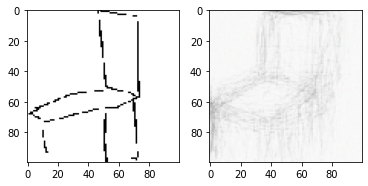

In [33]:
for i, data in enumerate(chairs_loader):
    img_shape = data.shape
    data = data.view(-1, data.shape[1]*data.shape[2]*data.shape[3])
    outputs = model_chairs(data)

    f, axarr = plt.subplots(1,2)
    
    inp_image_tensor = data.reshape(img_shape)
    inp_image = inp_image_tensor.squeeze(0).detach().cpu().numpy()
    inp_image = inp_image[0, :,:,:].transpose(1,2,0)
    
    out_image_tensor = outputs.reshape(img_shape)
    out_image = out_image_tensor.squeeze(0).detach().cpu().numpy()
    out_image = out_image[0, :,:,:].transpose(1,2,0)

    axarr[0].imshow(inp_image)
    axarr[1].imshow(out_image)

In [34]:
PATH = "../Models/muna_autoencoder.pt" #change this {chosen encode}_autoencoder.pt
torch.save(model_chairs.state_dict(), PATH)

## Experiment 2: 

### Variational AutoEncoder, using the reparameterization trick to previous model
---

In [35]:
class VAE(AutoEncoder):
    # IMPLEMENT THIS VAE CLASS
    def __init__(self,bottleneck_size):
        super(VAE, self).__init__(bottleneck_size)
        # INITIALIZE YOUR TRAINING PARAMETERS HERE.
        input_shape = image_size**2*3
        self.enc_h1 = nn.Linear(in_features=input_shape, out_features=50)
        self.mu_h2 = nn.Linear(in_features=50, out_features=bottleneck_size)
        self.logVar_h2 = nn.Linear(in_features=50, out_features=bottleneck_size)
        
        self.dec_h1 = nn.Linear(in_features=bottleneck_size, out_features=50)
        self.dec_out = nn.Linear(in_features=50, out_features=input_shape)
    
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE.
        h1_ac = torch.relu(self.enc_h1(image))
        mu = self.mu_h2(h1_ac)
        logVar = self.logVar_h2(h1_ac)
        std = logVar.mul(0.5).exp_()
        return mu, std
    
    def reparametrization_trick(self, mu, std):
        # WRITE THE REPARAMETRIZATION TRICK HERE.
        eps = Variable(std.data.new(std.size()).normal_())
        z = eps.mul(std).add_(mu)
        return z
    
    def forward(self, image):
        # PUT IT TOGETHER HERE
        mu, std = self.encoder(image.view(-1, image_size**2*3))
        z = self.reparametrization_trick(mu, std)
        decoded_image = self.decoder(z)
        return decoded_image, mu, std

### Training
---

In [39]:
# Loss functions
def kl_divergence_loss(mu,std,batch_size):
    # WRITE YOUR KL-DIVERGENCE LOSS CODE HERE
    # KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    log_var = torch.log(torch.pow(std, 2))
    loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    kl_loss = loss /(batch_size*image_size*2)
    return kl_loss

def reconstruction_loss(yPredict, target):
    # WRITE YOUR L2 RECONSTRUCTION LOSS HERE
    criterion = nn.MSELoss()
    recon_loss = criterion(yPredict, target)
    return recon_loss

def loss_function(yPredict, target, mu, std, batch_size):
    return reconstruction_loss(yPredict, target) + kl_divergence_loss(mu, std, batch_size)

# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
epochs = 100 # CHOOSE YOUR EPOCH SIZE TO GET BEST RESULTS
# USE THE TORCH API TO WRITE YOUR OPTIMIZER HERE

chairs_bottleneck_size = 25

model_chair_vae = VAE(chairs_bottleneck_size)

# Optimizer section, using Adam
chairs_optimizer = optim.Adam(model_chair_vae.parameters(), lr=1e-3) 

# IN THE TRAINING LOOPS BELOW, USE THE DEFINED NETWORK, LOSS FUNCTION AND OPTIMIZER.
train_loss = 0
for ep in range(epochs):
    loss = 0
    for i,data in enumerate(torch_train_chairs):
        # WRITE YOUR CelebA TRAINING LOOP HERE.
            
        # reshape mini-batch data to [N, 784] matrix so it can be loaded
        data = data.view(-1, data.shape[1]*data.shape[2]*data.shape[3])
        
        # resetting the gradients back to zero, pytorch accumulates gradients each backward pass
        chairs_optimizer.zero_grad()
        
        # encoder layer pass, compute the reconstructions
        new_img, mu, std = model_chair_vae(data)
        
        # compute loss to optimize reconstruction with
        train_loss = loss_function(new_img, data, mu, std, batch_size)
        
        # back propagation
        train_loss.backward()
        
        # update parameters
        chairs_optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    loss = loss / 100
    
    #train_loss.append(loss)
    print(f'Epoch {ep+1} of {epochs}, Train Loss: {loss:.5f}')


Epoch 1 of 100, Train Loss: 7.72636
Epoch 2 of 100, Train Loss: 1.60245
Epoch 3 of 100, Train Loss: 4.77432
Epoch 4 of 100, Train Loss: 0.54197
Epoch 5 of 100, Train Loss: 0.08468
Epoch 6 of 100, Train Loss: 0.02828
Epoch 7 of 100, Train Loss: 0.01410
Epoch 8 of 100, Train Loss: 0.00903
Epoch 9 of 100, Train Loss: 0.00688
Epoch 10 of 100, Train Loss: 0.00613
Epoch 11 of 100, Train Loss: 0.00593
Epoch 12 of 100, Train Loss: 0.00586
Epoch 13 of 100, Train Loss: 0.00575
Epoch 14 of 100, Train Loss: 0.00574
Epoch 15 of 100, Train Loss: 0.00551
Epoch 16 of 100, Train Loss: 0.00542
Epoch 17 of 100, Train Loss: 0.00535
Epoch 18 of 100, Train Loss: 0.00543
Epoch 19 of 100, Train Loss: 0.00520
Epoch 20 of 100, Train Loss: 0.00505
Epoch 21 of 100, Train Loss: 0.00500
Epoch 22 of 100, Train Loss: 0.00473
Epoch 23 of 100, Train Loss: 0.00473
Epoch 24 of 100, Train Loss: 0.00459
Epoch 25 of 100, Train Loss: 0.00444
Epoch 26 of 100, Train Loss: 0.00448
Epoch 27 of 100, Train Loss: 0.00445
Epoch 28 o

### Testing
---

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


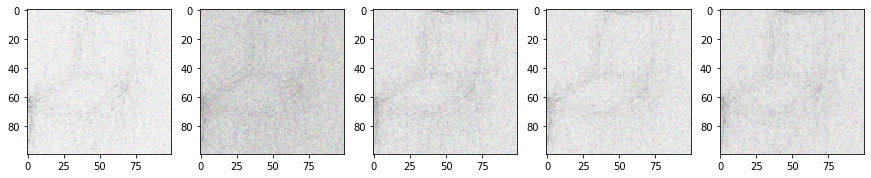

In [43]:
number_of_samples = 5

random_chair_images =[]
### Chair sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,chairs_bottleneck_size)
    
    ### Use the random code, to generate CelebA images with your trained Auto-Encoder
    random_normal_code = random_normal_code
    outputs = model_chair_vae.decoder(random_normal_code)
    
    output_img_tensor = outputs.cpu().reshape(1, 3, image_size, image_size).squeeze(0)
    output_img = np.array(torchvision.transforms.ToPILImage()(output_img_tensor))

    random_chair_images.append(output_img)

f, axarr = plt.subplots(1,5, figsize=(15,15))
for i, img in enumerate(random_chair_images):
    axarr[i].imshow(img)
f.show()

In [44]:
# Saving model

PATH = "../Models/muna_vaencoder.pt"
torch.save(model_chair_vae.state_dict(), PATH)


### Comparing Experiment 1 and 2
---
Feeding noisy images to the decoders of AE and VAE models, to see which models produce better results

/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/muna/anaconda3/envs/env_pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


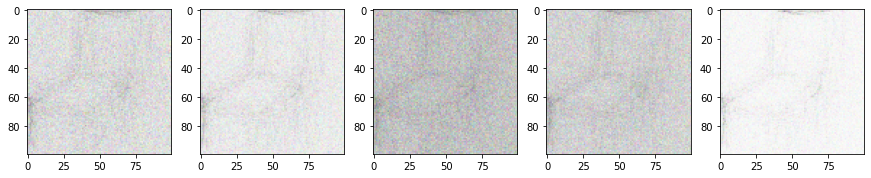

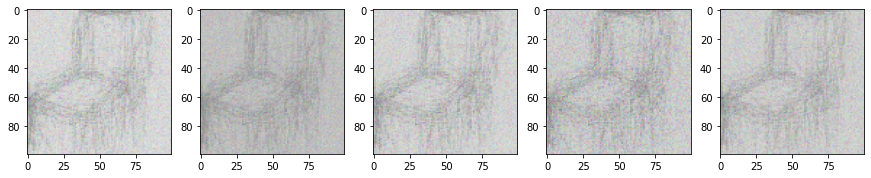

In [46]:
# Reproducing images using VAE

number_of_samples = 5

random_chair_images =[]
### Chair sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,chairs_bottleneck_size)
    
    ### Use the random code, to generate chair images with your trained Variational Auto-Encoder
    random_normal_code = random_normal_code
    outputs = model_chair_vae.decoder(random_normal_code) # passing to decoder
    
    output_img_tensor = outputs.cpu().reshape(1, 3, image_size, image_size).squeeze(0)
    output_img = np.array(torchvision.transforms.ToPILImage()(output_img_tensor))

    random_chair_images.append(output_img)

f, axarr = plt.subplots(1,5, figsize=(15,15))
for i, img in enumerate(random_chair_images):
    axarr[i].imshow(img)
f.show()

# Reproducing images using AE

number_of_samples = 5

random_chair_images =[]
### Chair sample generation
for i in range(number_of_samples):
    random_normal_code = torch.randn(1,chairs_bottleneck_size)
    
    ### Use the random code, to generate chair images with your trained Auto-Encoder
    random_normal_code = random_normal_code
    outputs = model_chairs.decoder(random_normal_code) # passing to decoder of AE
    
    output_img_tensor = outputs.cpu().reshape(1, 3, image_size, image_size).squeeze(0)
    output_img = np.array(torchvision.transforms.ToPILImage()(output_img_tensor))

    random_chair_images.append(output_img)

f, axarr = plt.subplots(1,5, figsize=(15,15))
for i, img in enumerate(random_chair_images):
    axarr[i].imshow(img)
f.show()

Can see here that the AE appears to produce clearer sketch-like images

## Experiment 3: 
### Using Pytorch's VGG
---